In [1]:
"""
train_densenet121.py
DenseNet-121 transfer learning.
"""

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, mean_squared_error, confusion_matrix

DATA_DIR = r"D:\maize_project\Dataset"
TRAIN_DIR = os.path.join(DATA_DIR,'train')
VAL_DIR = os.path.join(DATA_DIR,'val')
TEST_DIR = os.path.join(DATA_DIR,'test')
IMG_SIZE=(224,224); BATCH_SIZE=16; EPOCHS=25
OUT_DIR='densenet121_results'; os.makedirs(OUT_DIR, exist_ok=True)

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.1, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
train_flow = train_gen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_flow = val_gen.flow_from_directory(VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = val_gen.flow_from_directory(TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

NUM_CLASSES = train_flow.num_classes

base = DenseNet121(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))
base.trainable = False
x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = models.Model(base.input, outputs)
model.compile(optimizer=optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

chk = ModelCheckpoint(os.path.join(OUT_DIR,'densenet_best.h5'), monitor='val_accuracy', save_best_only=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit(train_flow, validation_data=val_flow, epochs=EPOCHS, callbacks=[chk, rlr, es])

# save plots
plt.figure(); plt.plot(history.history['accuracy'], label='train'); plt.plot(history.history['val_accuracy'], label='val'); plt.legend(); plt.savefig(os.path.join(OUT_DIR,'accuracy.png')); plt.close()
plt.figure(); plt.plot(history.history['loss'], label='train'); plt.plot(history.history['val_loss'], label='val'); plt.legend(); plt.savefig(os.path.join(OUT_DIR,'loss.png')); plt.close()

# Evaluate
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow, steps=int(np.ceil(test_flow.samples/BATCH_SIZE)))
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, mean_squared_error, confusion_matrix
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
mse = mean_squared_error(y_true, y_pred)
logloss = log_loss(tf.keras.utils.to_categorical(y_true, NUM_CLASSES), y_pred_probs)
try:
    auc_roc = roc_auc_score(tf.keras.utils.to_categorical(y_true, NUM_CLASSES), y_pred_probs, multi_class='ovr')
except:
    auc_roc = float('nan')

cm = confusion_matrix(y_true, y_pred)
specificities = []
for i in range(NUM_CLASSES):
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    fp = cm[:,i].sum() - cm[i,i]
    specificities.append(tn/(tn+fp) if (tn+fp)>0 else 0.0)
specificity = np.mean(specificities)

metrics = {"accuracy":acc,"precision":precision,"recall":recall,"f1_score":f1,"specificity":specificity,"mse":mse,"logloss":logloss,"auc_roc":auc_roc}
pd.DataFrame([metrics]).to_csv(os.path.join(OUT_DIR,'metrics_densenet121.csv'), index=False)
model.save(os.path.join(OUT_DIR,'densenet121_final.h5'))
print("Done:", OUT_DIR)


Found 2930 images belonging to 4 classes.
Found 628 images belonging to 4 classes.
Found 630 images belonging to 4 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

C:\Users\devia\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5819 - loss: 1.0278  

184/184 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.6887 - loss: 0.7684 - val_accuracy: 0.8662 - val_loss: 0.3898 - learning_rate: 1.0000e-04
Epoch 2/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8317 - loss: 0.4334  

184/184 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.8399 - loss: 0.4124 - val_accuracy: 0.8838 - val_loss: 0.3243 - learning_rate: 1.0000e-04
Epoch 3/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8600 - loss: 0.3331  

184/184 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.8720 - loss: 0.3285 - val_accuracy: 0.8869 - val_loss: 0.2881 - learning_rate: 1.0000e-04
Epoch 4/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8934 - loss: 0.2893  

184/184 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.8836 - loss: 0.2924 - val_accuracy: 0.9076 - val_loss: 0.2577 - learning_rate: 1.0000e-04
Epoch 5/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.8976 - loss: 0.2676 - val_accuracy: 0.9013 - val_loss: 0.2545 - learning_rate: 1.0000e-04
Epoch 6/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8994 - loss: 0.2524  

184/184 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.9096 - loss: 0.2345 - val_accuracy: 0.9092 - val_loss: 0.2338 - learning_rate: 1.0000e-04
Epoch 7/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9178 - loss: 0.2185  

184/184 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.9123 - loss: 0.2265 - val_accuracy: 0.9140 - val_loss: 0.2291 - learning_rate: 1.0000e-04
Epoch 8/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9166 - loss: 0.2091  

184/184 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.9123 - loss: 0.2223 - val_accuracy: 0.9156 - val_loss: 0.2234 - learning_rate: 1.0000e-04
Epoch 9/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 1090s 6s/step - accuracy: 0.9184 - loss: 0.2128 - val_accuracy: 0.9092 - val_loss: 0.2227 - learning_rate: 1.0000e-04
Epoch 10/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.9266 - loss: 0.1972 - val_accuracy: 0.9156 - val_loss: 0.2171 - learning_rate: 1.0000e-04
Epoch 11/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.9232 - loss: 0.1992 - val_accuracy: 0.9156 - val_loss: 0.2114 - learning_rate: 1.0000e-04
Epoch 12/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9315 - loss: 0.1853  

184/184 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9311 - loss: 0.1831 - val_accuracy: 0.9188 - val_loss: 0.2053 - learning_rate: 1.0000e-04
Epoch 13/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.9352 - loss: 0.1754 - val_accuracy: 0.9172 - val_loss: 0.2022 - learning_rate: 1.0000e-04
Epoch 14/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9414 - loss: 0.1653  

184/184 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.9358 - loss: 0.1686 - val_accuracy: 0.9204 - val_loss: 0.2008 - learning_rate: 1.0000e-04
Epoch 15/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.9369 - loss: 0.1702 - val_accuracy: 0.9172 - val_loss: 0.2061 - learning_rate: 1.0000e-04
Epoch 16/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9274 - loss: 0.1698  

184/184 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9317 - loss: 0.1656 - val_accuracy: 0.9268 - val_loss: 0.2050 - learning_rate: 1.0000e-04
Epoch 17/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.9433 - loss: 0.1543 - val_accuracy: 0.9172 - val_loss: 0.2107 - learning_rate: 1.0000e-04
Epoch 18/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9396 - loss: 0.1495 - val_accuracy: 0.9220 - val_loss: 0.1970 - learning_rate: 5.0000e-05
Epoch 19/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9416 - loss: 0.1475 - val_accuracy: 0.9252 - val_loss: 0.1935 - learning_rate: 5.0000e-05
Epoch 20/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9454 - loss: 0.1441 - val_accuracy: 0.9236 - val_loss: 0.1924 - learning_rate: 5.0000e-05
Epoch 21/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9335 - loss: 0.1652  

184/184 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.9437 - loss: 0.1490 - val_accuracy: 0.9283 - val_loss: 0.1932 - learning_rate: 5.0000e-05
Epoch 22/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.9427 - loss: 0.1462 - val_accuracy: 0.9204 - val_loss: 0.1977 - learning_rate: 5.0000e-05
Epoch 23/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9437 - loss: 0.1389  

184/184 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9420 - loss: 0.1417 - val_accuracy: 0.9299 - val_loss: 0.1888 - learning_rate: 5.0000e-05
Epoch 24/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.9478 - loss: 0.1378 - val_accuracy: 0.9283 - val_loss: 0.1841 - learning_rate: 5.0000e-05
Epoch 25/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.9468 - loss: 0.1350 - val_accuracy: 0.9299 - val_loss: 0.1827 - learning_rate: 5.0000e-05
40/40 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step  


Done: densenet121_results


Done: densenet121_results

===== DenseNet121 Evaluation Results =====
accuracy    : 0.9397
precision   : 0.9405
recall      : 0.9397
f1_score    : 0.9400
specificity : 0.9805
mse         : 0.1937
logloss     : 0.1541
auc_roc     : 0.9916


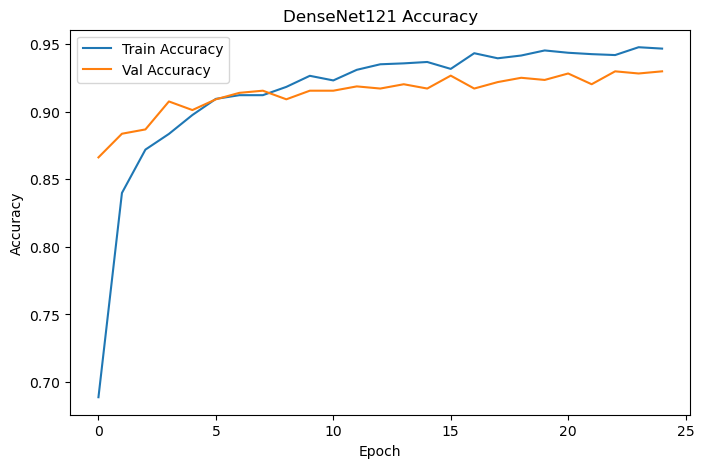

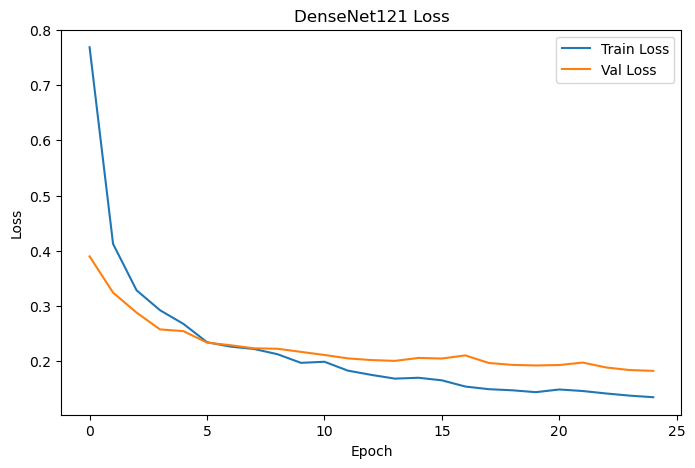

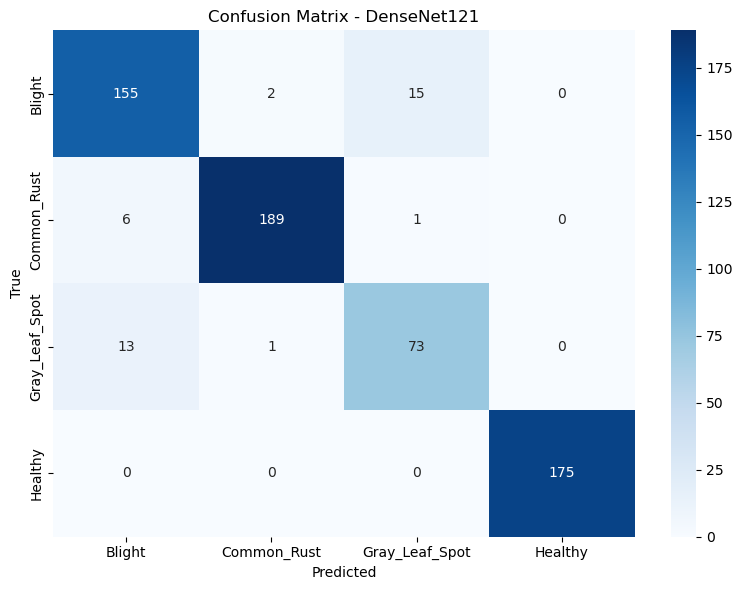

In [4]:
print("Done:", OUT_DIR)

# ================= SHOW METRICS =================
print("\n===== DenseNet121 Evaluation Results =====")
for k,v in metrics.items():
    print(f"{k:12s}: {v:.4f}")

# ================= PLOT TRAINING CURVES =================
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("DenseNet121 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("DenseNet121 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ================= CONFUSION MATRIX =================
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_flow.class_indices.keys(),
            yticklabels=test_flow.class_indices.keys())
plt.title("Confusion Matrix - DenseNet121")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
